In [2]:
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
result_df = pd.read_csv("results.csv")
result_df.head()

,framework,model,dataset,quantization,accuracy,std_err
0,paper,Llama-2-7b,winogrande,NaN,0.6920,NaN
1,paper,Llama-2-7b,arc_easy,NaN,0.7520,NaN
2,paper,Llama-2-7b,arc_challenge,NaN,0.4590,NaN
3,paper,Llama-2-7b,truthfulqa_mc,NaN,0.3329,NaN
4,paper,Llama-2-7b,hellaswag,NaN,0.7720,NaN


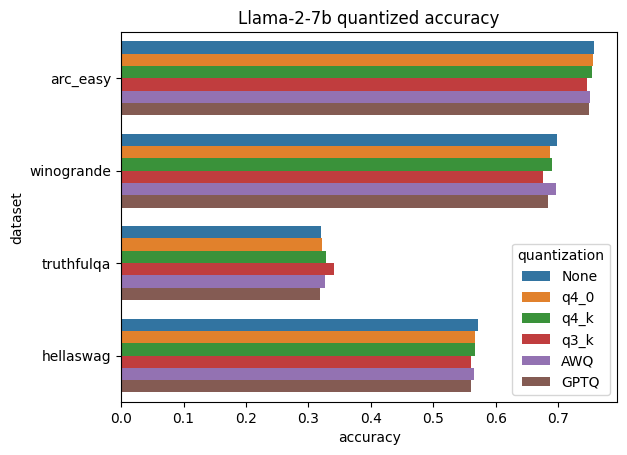

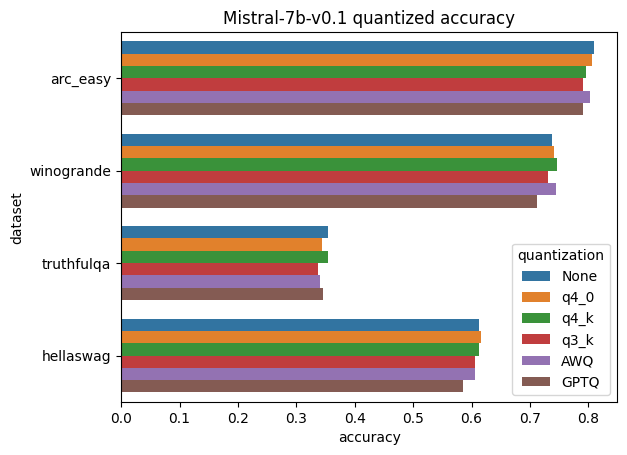

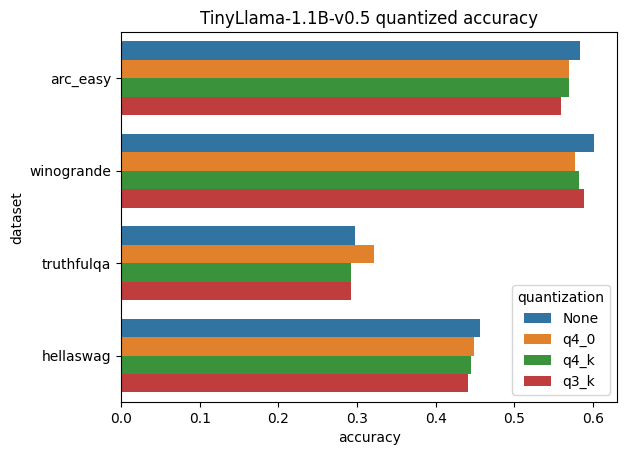

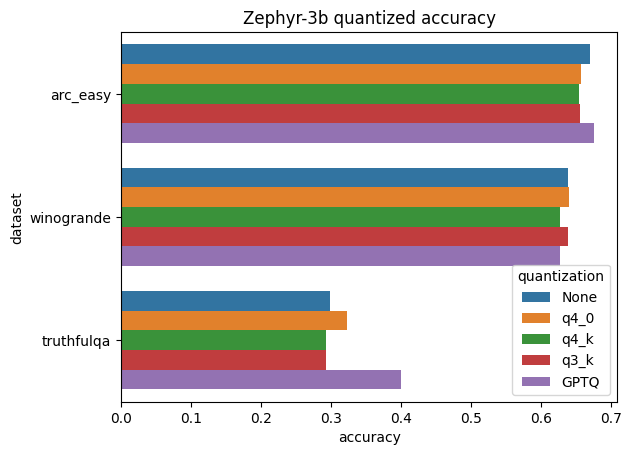

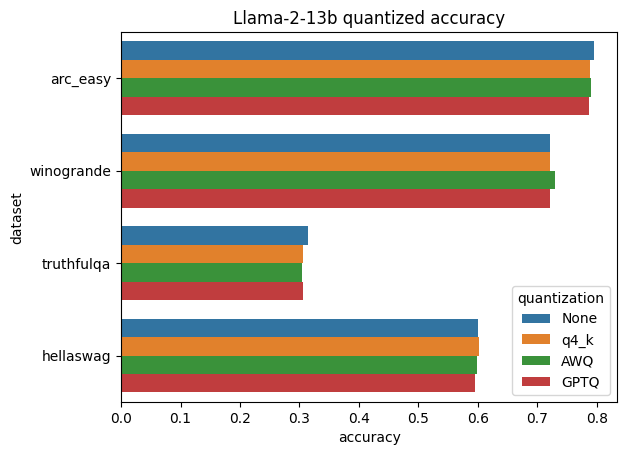

In [4]:
# model results
models = result_df["model"].unique()

for model_name in models:
  llama_df = result_df[result_df["model"] == model_name]
  llama_df = llama_df[llama_df["framework"] != "paper"]
  llama_df = llama_df[llama_df["dataset"].isin(["winogrande", "arc_easy", "truthfulqa", "hellaswag"])]
  llama_df.loc[llama_df["quantization"].isna(),"quantization"] = "None"
  llama_df = llama_df[llama_df["quantization"].isin(["q4_0", "q4_k", "q3_k", "AWQ", "GPTQ", "None"])]
  ax = sns.barplot(x="accuracy", y="dataset", hue="quantization", hue_order=[label for label in ["None", "q4_0", "q4_k", "q3_k", "AWQ", "GPTQ"] if label in llama_df.quantization.unique()], data=llama_df, orient='h')
  ax.set_title(f"{model_name} quantized accuracy")
  plt.savefig(f"figures/{model_name}_quantized_accuracy.png", dpi=300, bbox_inches='tight')
  plt.show()

In [5]:
specs_df = pd.read_csv("model_specs.csv")
specs_df.loc[specs_df["quantization"].isna(),"quantization"] = "None"
specs_df.head()

,model,quantization,size,size_in_memory,parameters,max_ram
0,Mistral-7b-v0.1,None,14.48,13.49,7240000,NaN
1,Mistral-7b-v0.1,q3_k,3.52,3.28,7240000,6.02
2,Mistral-7b-v0.1,q4_k,4.37,4.07,7240000,6.87
3,Mistral-7b-v0.1,q4_0,4.11,3.83,7240000,6.61
4,Mistral-7b-v0.1,AWQ,4.15,4.47,7240000,NaN


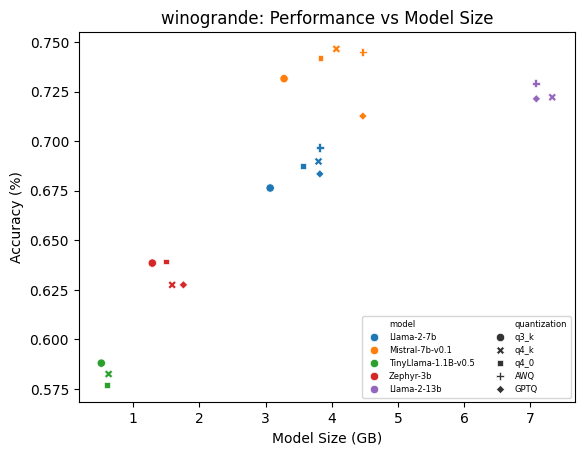

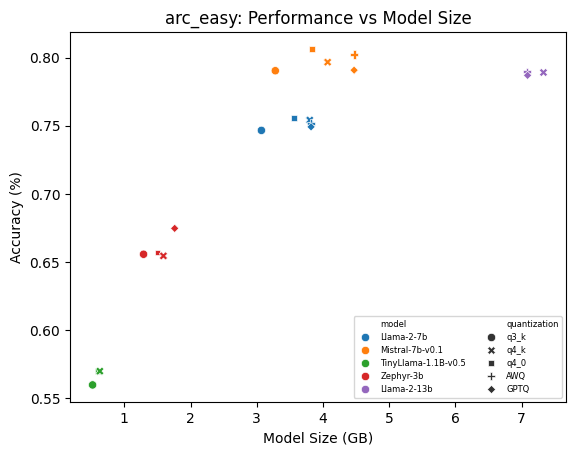

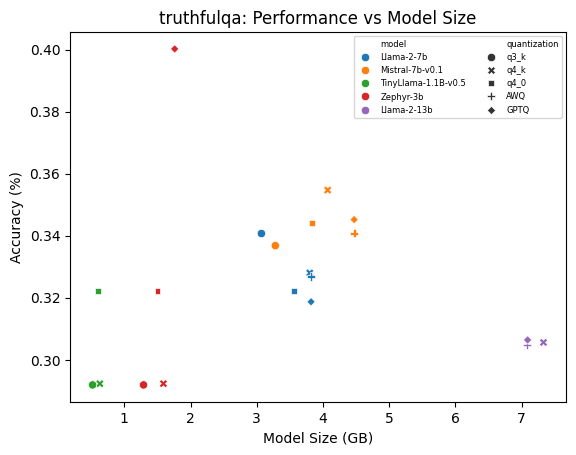

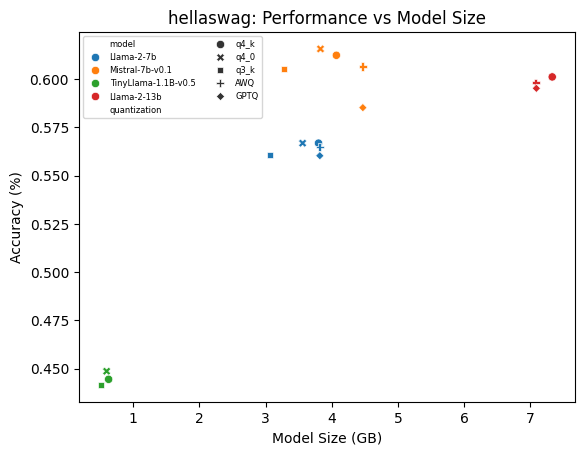

In [6]:
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

# Filter the dataframe for the desired datasets
datasets = ["winogrande", "arc_easy", "truthfulqa", "hellaswag"]
filtered_df = result_df[result_df["dataset"].isin(datasets)]
filtered_df = filtered_df[filtered_df["framework"] != "paper"]

# Create a separate plot for each dataset
for dataset in datasets:
  dataset_df = filtered_df[filtered_df["dataset"] == dataset]
  #dataset_df.loc[dataset_df["quantization"].isna(),"quantization"] = "None"
  dataset_df = dataset_df.merge(specs_df, on=("model","quantization"))

  # Create a single plot for the model in the dataset
  plt.figure()
  ax = sns.scatterplot(x="size_in_memory", y="accuracy", hue="model", style="quantization", data=dataset_df)

  ax.set_title(f"{dataset}: Performance vs Model Size")
  ax.set_xlabel("Model Size (GB)")
  ax.set_ylabel("Accuracy (%)")
  ax.legend(prop={'size': 6}, ncol=2)
  plt.savefig(f"figures/{dataset}_performance_vs_size.png", dpi=300, bbox_inches='tight')
  plt.show()

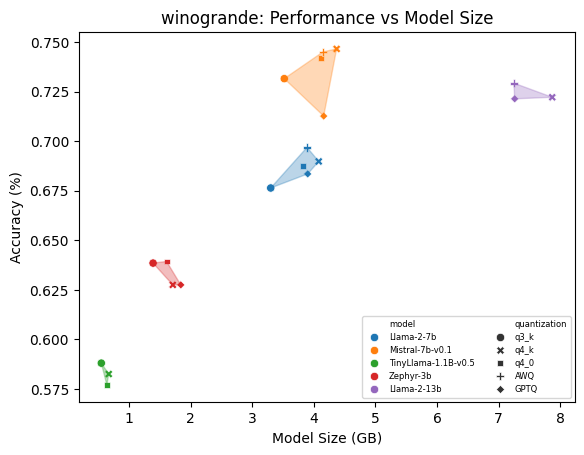

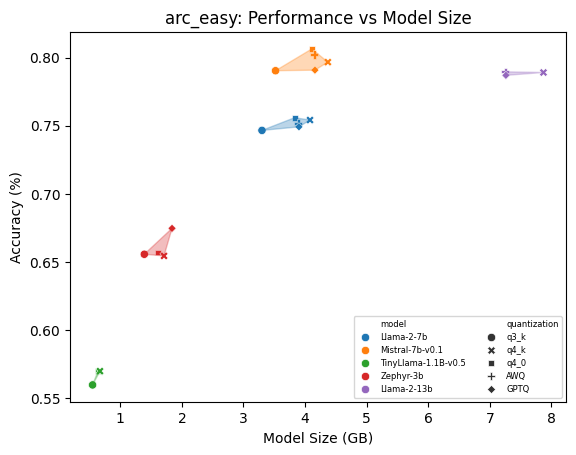

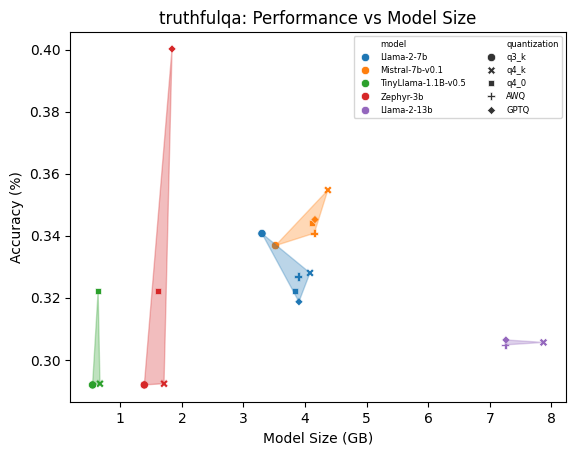

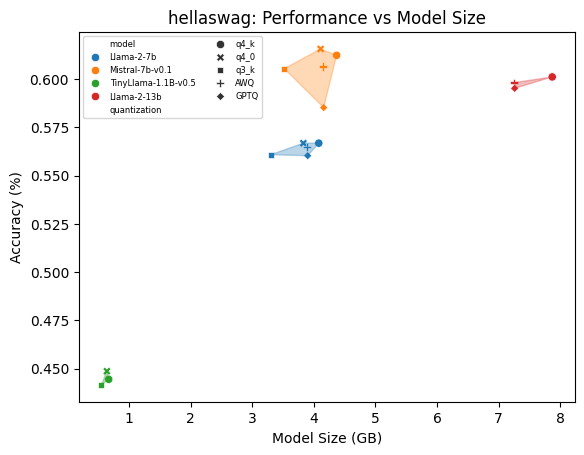

In [23]:
from scipy.spatial import ConvexHull
import numpy as np

datasets = ["winogrande", "arc_easy", "truthfulqa", "hellaswag"]
filtered_df = result_df[result_df["dataset"].isin(datasets)]
filtered_df = filtered_df[filtered_df["framework"] != "paper"]

# Create a separate plot for each dataset
for dataset in datasets:
  dataset_df = filtered_df[filtered_df["dataset"] == dataset]
  dataset_df = dataset_df.merge(specs_df, on=("model","quantization"))

  # Create a single plot for the model in the dataset
  plt.figure()
  ax = sns.scatterplot(x="size", y="accuracy", hue="model", style="quantization", data=dataset_df)

  # Draw convex hulls for each model
  models = dataset_df["model"].unique()
  for model in models:
    model_df = dataset_df[dataset_df["model"] == model]
    points = model_df[["size", "accuracy"]].values
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]
    hull_points = np.append(hull_points, hull_points[0:1], axis=0)

    color = sns.color_palette("tab10")[models.tolist().index(model)]
    ax.fill(hull_points[:, 0], hull_points[:, 1], color=to_rgba(color, 0.3))

  ax.set_title(f"{dataset}: Performance vs Model Size")
  ax.set_xlabel("Model Size (GB)")
  ax.set_ylabel("Accuracy (%)")
  ax.legend(prop={'size': 6}, ncol=2)
  plt.savefig(f"figures/{dataset}_performance_vs_size.png", dpi=300, bbox_inches='tight')
  plt.show()